# <b> Лабораторна робота №4
"Метод k найближчих сусідів"\
Виконала: Челюскіна Юлія КМ-21 (2-га підгрупа)

---

## Відстані

* Евклідова відстань (Euclidean distance)\
Застосування: стандартна метрика для числових даних, коли всі ознаки мають однакову шкалу.
* Манхеттенська відстань\
Застосування: коли важливо враховувати абсолютні відмінності; стійкіша до викидів.
* Мінімальна/максимальна (Chebyshev) відстань\
Застосування: коли розрахунок залежить від найбільшої різниці в одній координаті.
* Косинусна відстань\
Застосування: при роботі з текстовими даними, векторними представленнями слів (наприклад, у NLP).
* Джака́рда (Jaccard) та Соренсена-Дайса (Sørensen-Dice)\
Застосування: для бінарних/категоріальних ознак, зокрема в біоінформатиці, екології, сегментації зображень.


## Початкові дані (1-3)

In [1]:
import pandas as pd
df  = pd.read_csv("ЛР4-пгр2.csv", delimiter=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [2]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 1599
Number of columns: 12


In [3]:
df.columns.tolist()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

## Поділ датасету (4)

In [6]:
from sklearn.model_selection import ShuffleSplit
X = df.drop(columns=['quality'])  # всі стовпчики, крім 'quality'
y = df['quality']  # цільова змінна 'quality'
ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
splits = list(ss.split(X, y)) ##індекси зразків

train_idx, test_idx = splits[7] # 8

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [7]:
print("Train class balance (percent):", y_train.value_counts(normalize=True) * 100)
print("Test class balance (percent):", y_test.value_counts(normalize=True) * 100)

Train class balance (percent): quality
5    42.220485
6    39.953088
7    12.040657
4     3.752932
8     1.329163
3     0.703675
Name: proportion, dtype: float64
Test class balance (percent): quality
5    44.0625
6    39.6875
7    14.0625
4     1.5625
3     0.3125
8     0.3125
Name: proportion, dtype: float64


## функції

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef
)

#вивід метрик зважених
def evaluate_metrics(y_test, y_pred):
    # Обчислення основних метрик з назвами
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "Matthews Correlation Coefficient": matthews_corrcoef(y_test, y_pred)
    }

    for name, value in metrics.items():
        print(f"{name}: {value}")

    ok_metrics = ["F1 Score", "Balanced Accuracy", "Matthews Correlation Coefficient"]

    return {k: metrics[k] for k in ok_metrics if k in metrics}

In [112]:
def plot_comparison(metrics_test, metrics_train):
    # Декілька метрик для порівняння
    metrics_names = ['F1 Score', 'Balanced Accuracy', 'Matthews Correlation Coefficient']
    
    # Значення метрик для тесту та навчання
    test_values = [metrics_test[name] for name in metrics_names]
    train_values = [metrics_train[name] for name in metrics_names]
    
    # Створюємо графік
    x = range(len(metrics_names))
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(x, test_values, width=0.4, label="Test", align='center', alpha=0.7)
    plt.bar(x, train_values, width=0.4, label="Train", align='edge', alpha=0.7)
    
    plt.xticks(x, metrics_names)
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Comparison of Metrics: Test vs Train')
    plt.legend()
    
    plt.show()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_model_comparison(model1, model2, model1_name, model2_name):
    # Передбачення для кожної моделі
    y_pred_1 = model1.predict(X_test)  # Для model1
    y_pred_2 = model2.predict(X_test)  # Для model2

    # Створюємо фігуру з двома колонками
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Виводимо перший графік (для model1)
    cm_model1 = confusion_matrix(y_test, y_pred_1, labels=model1.classes_)
    disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1, display_labels=model1.classes_)
    disp_model1.plot(ax=axes[0]) 
    axes[0].set_title(model1_name)

    # Виводимо другий графік (для model2)
    cm_model2 = confusion_matrix(y_test, y_pred_2, labels=model2.classes_)
    disp_model2 = ConfusionMatrixDisplay(confusion_matrix=cm_model2, display_labels=model2.classes_)
    disp_model2.plot(ax=axes[1]) 
    axes[1].set_title(model2_name)

    # Покажемо графіки
    plt.tight_layout() 
    plt.show()

    # Створимо графіки для правильних/помилкових класифікацій
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 7))

    # Графік для model1 - правильні і помилкові класифікації
    ax2 = axes2[0]
    labels = model1.classes_
    for i, label in enumerate(labels):
        real_class_count = cm_model1[i, :].sum()  # Всього зразків цього класу
        correct_class_count = cm_model1[i, i]    # Правильно класифіковані як цей клас
        other_class_count = real_class_count - correct_class_count  # Помилково класифіковані як інші

        ax2.bar(i, correct_class_count, color='green', label='Correct' if i == 0 else "")
        ax2.bar(i, other_class_count, bottom=correct_class_count, color='orange', label='Incorrect' if i == 0 else "")

    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels)
    ax2.set_title(f'Classification per Class ({model1_name})')
    ax2.legend()

    # Графік для model2 - правильні і помилкові класифікації
    ax3 = axes2[1]
    labels = model2.classes_
    for i, label in enumerate(labels):
        real_class_count = cm_model2[i, :].sum()  # Всього зразків цього класу
        correct_class_count = cm_model2[i, i]    # Правильно класифіковані як цей клас
        other_class_count = real_class_count - correct_class_count  # Помилково класифіковані як інші

        ax3.bar(i, correct_class_count, color='green', label='Correct' if i == 0 else "")
        ax3.bar(i, other_class_count, bottom=correct_class_count, color='orange', label='Incorrect' if i == 0 else "")

    ax3.set_xticks(np.arange(len(labels)))
    ax3.set_xticklabels(labels)
    ax3.set_title(f'Classification per Class ({model2_name})')
    ax3.legend()

    # Покажемо графіки для правильних/помилкових класифікацій
    plt.tight_layout()
    plt.show()



In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef

def evaluate_knn_performance(model, X_test, y_test, plot_title="KNN Model Performance"):
    """
    Функція для оцінки впливу кількості сусідів (від 1 до 20) на метрики класифікації KNN.
    Модель вже має бути навчена перед викликом цієї функції.
    
    model: навчена модель класифікації.
    X_test: тестові дані.
    y_test: цільова змінна для тестових даних.
    plot_title: Назва графіку (для відображення на графіку).
    """

    neighbors_range = list(range(1, 21))
    f1_scores = []
    balanced_accuracy_scores = []
    mcc_scores = []

    # Обчислюємо метрики для різної кількості сусідів
    for n_neighbors in neighbors_range:
        # Зміна кількості сусідів для поточної моделі
        model.set_params(n_neighbors=n_neighbors)
        
        # Прогнозування на тестових даних
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        f1_scores.append(f1)
        balanced_accuracy_scores.append(balanced_acc)
        mcc_scores.append(mcc)

    # Побудова графіків на одній площині
    plt.figure(figsize=(10, 6))

    # Графік F1 Score
    plt.plot(neighbors_range, f1_scores, marker='o', label='F1 Score')

    # Графік Balanced Accuracy
    plt.plot(neighbors_range, balanced_accuracy_scores, marker='o', label='Balanced Accuracy')

    # Графік Matthews Correlation Coefficient (MCC)
    plt.plot(neighbors_range, mcc_scores, marker='o', label='MCC')

    # Оформлення графіка
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(plot_title)  # Встановлюємо назву графіку
    plt.legend()
    plt.grid(True)

    # Показати графік
    plt.tight_layout()
    plt.show()


## Створення моделей (5)

In [115]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as m

# Створення моделі k-NN (за замовчуванням)
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

* Варто звертати увагу на метрики, які більш стійкі до незбалансованості данних!

## Розгляд базової моделі

Accuracy: 0.5
Precision: 0.48495840097402604
Recall: 0.5
F1 Score: 0.484787077959716
Balanced Accuracy: 0.22150865893536356
Matthews Correlation Coefficient: 0.17060603859019507
Accuracy: 0.6528537920250196
Precision: 0.70175332836101
Recall: 0.6528537920250196
F1 Score: 0.6700234837256543
Balanced Accuracy: 0.5161414705463817
Matthews Correlation Coefficient: 0.44104764860550943


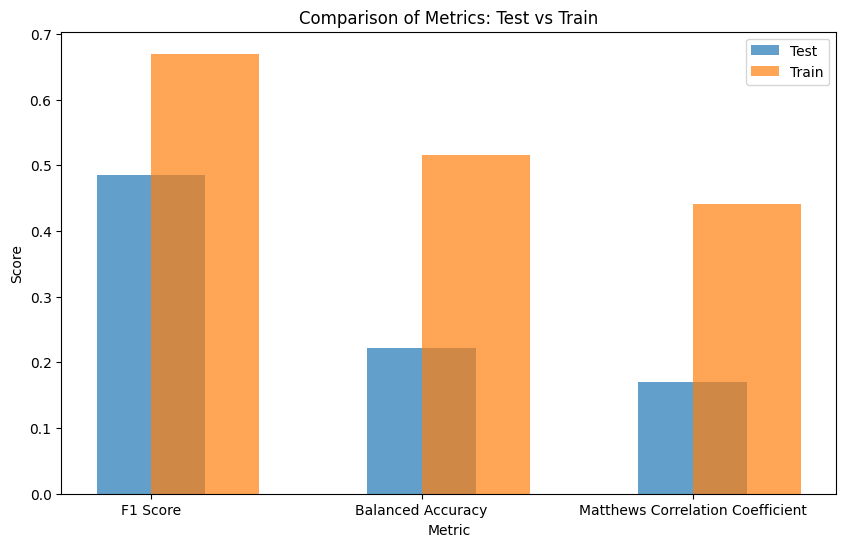

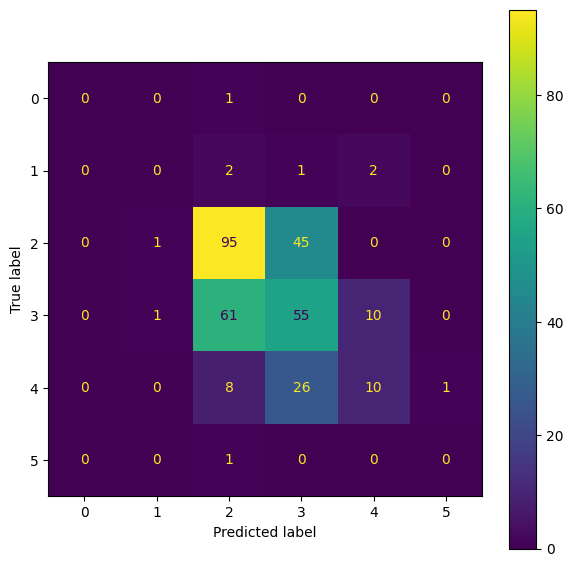

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

metrics_test = evaluate_metrics(y_test, y_pred)  # Для тесту
metrics_train = evaluate_metrics(y_pred_train, y_train)  # Для навчання

plot_comparison(metrics_test, metrics_train)

#матриця
cm_model1 = confusion_matrix(y_test, y_pred)
disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1)
fig, ax = plt.subplots(figsize=(7, 7))
disp_model1.plot(ax=ax)

plt.show()

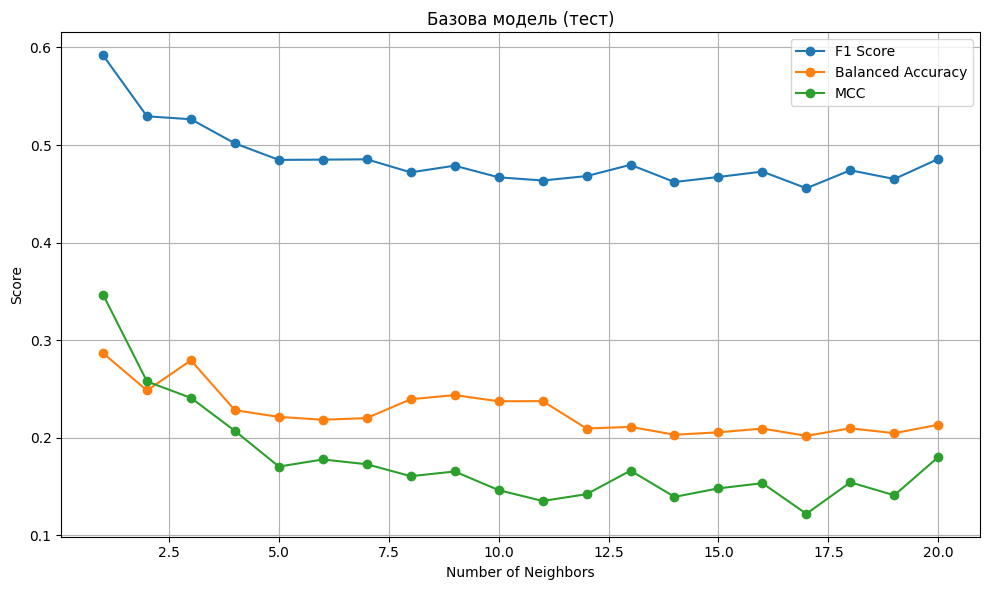

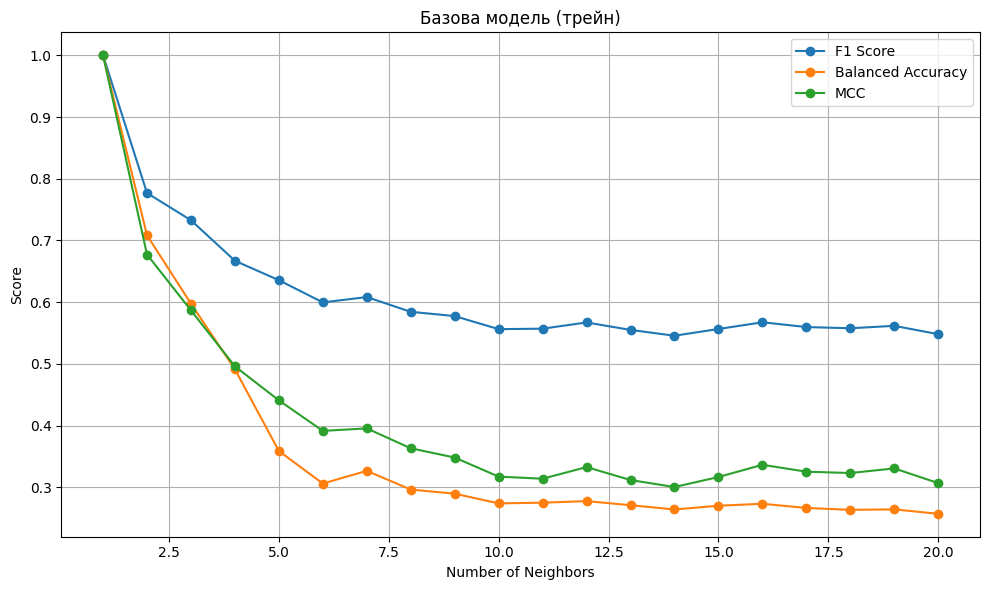

In [117]:
evaluate_knn_performance(knn, X_test, y_test, "Базова модель (тест)")
evaluate_knn_performance(knn, X_train, y_train, "Базова модель (трейн)")

## Спроби покращити модель

In [126]:
# Ініціалізація та навчання моделі kNN
knn_b = KNeighborsClassifier(weights='distance')
knn_b.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [127]:
from imblearn.over_sampling import SMOTE
# Ініціалізація SMOTE для збільшення кількості зразків міноритарного класу
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Застосування SMOTE до тренувальних даних
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Перевірка балансу класів після застосування SMOTE
print("Баланс класів після SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))

# Створення та навчання моделі KNN
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_train_res, y_train_res)


Баланс класів після SMOTE: {3: 540, 4: 540, 5: 540, 6: 540, 7: 540, 8: 540}


KNeighborsClassifier()

In [128]:
knn_ch = KNeighborsClassifier(metric='chebyshev', weights='distance')
knn_ch.fit(X_train, y_train)

KNeighborsClassifier(metric='chebyshev', weights='distance')

In [132]:
knn_a = KNeighborsClassifier(metric='manhattan', weights='distance')
knn_a.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

Література
https://aicompetence.org/handling-imbalanced-classes-in-knn/

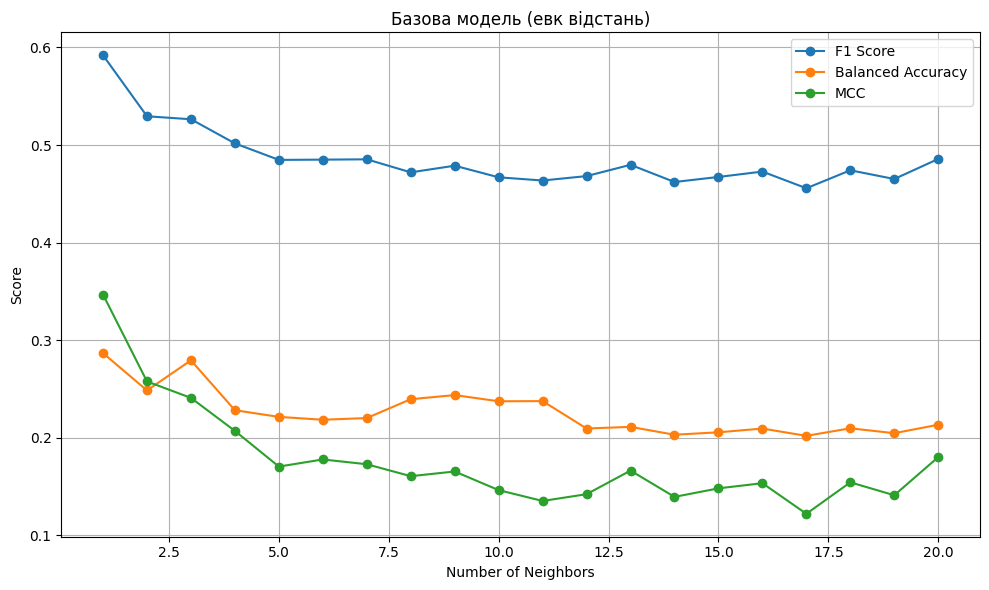

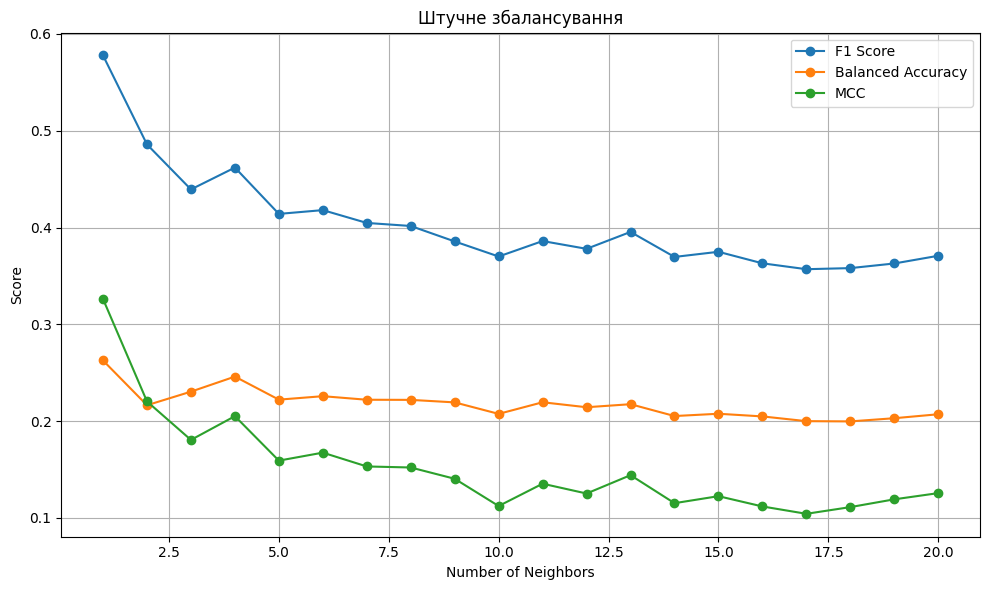

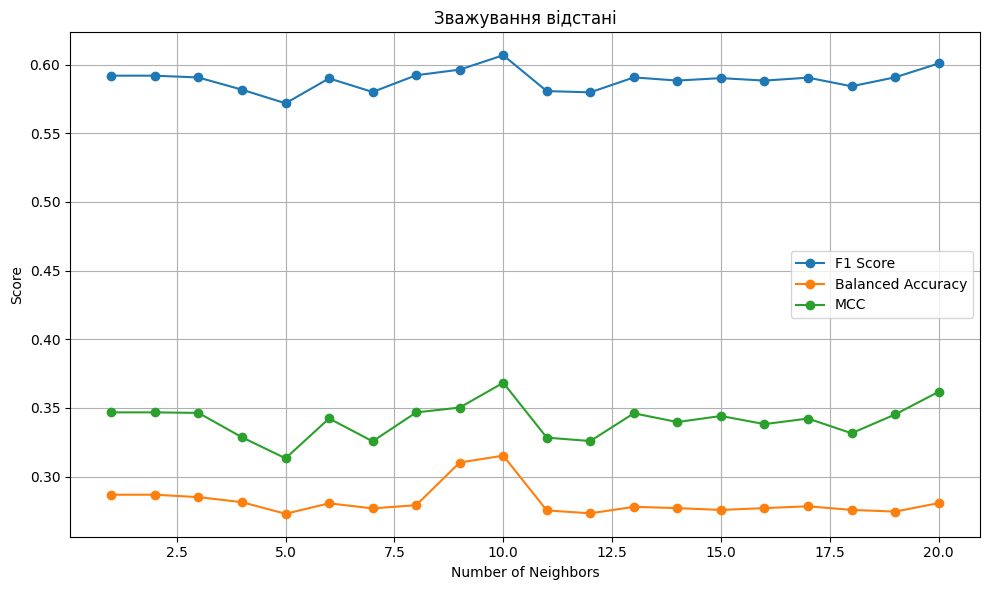

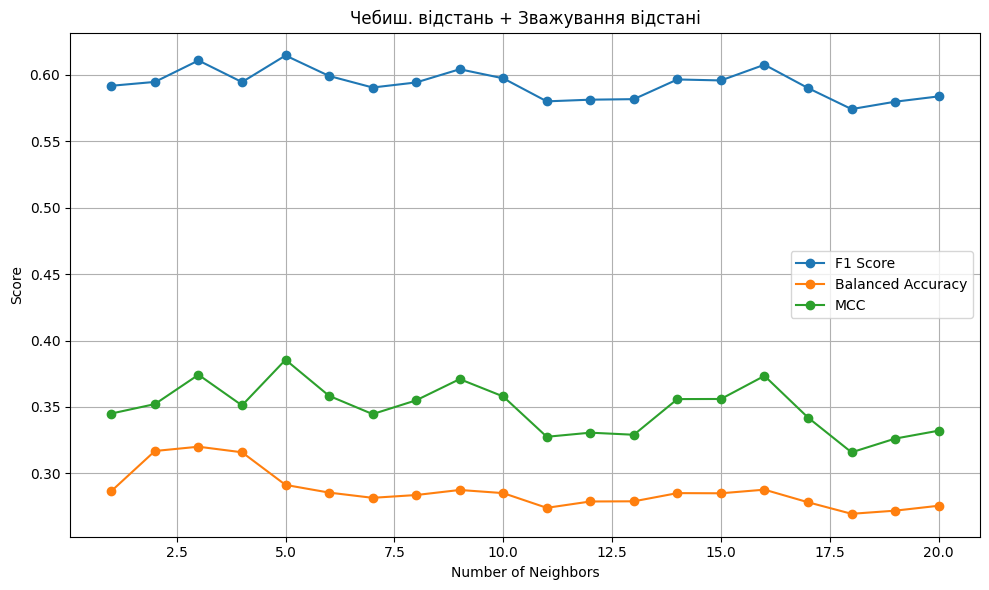

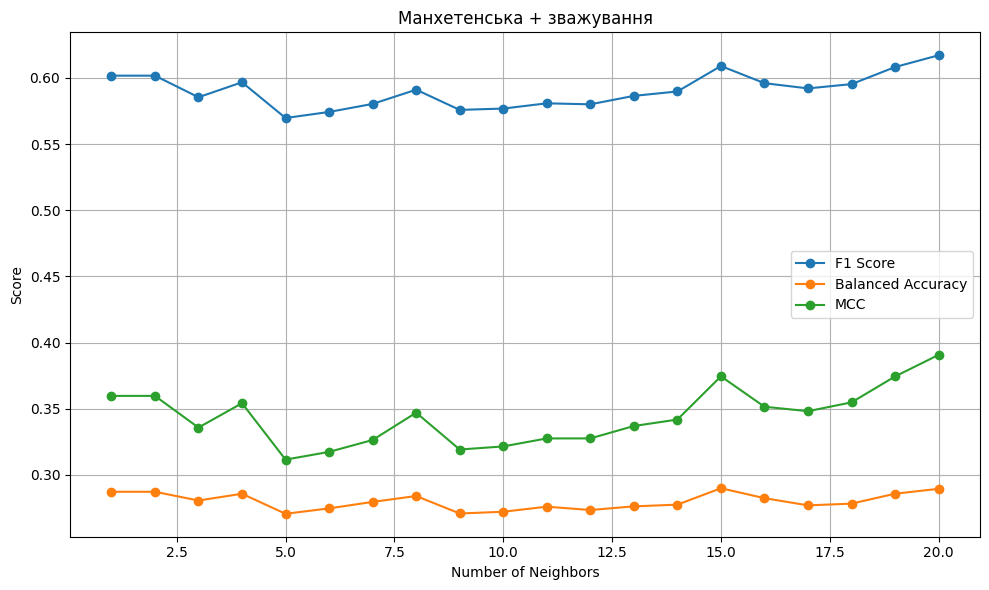

In [134]:
evaluate_knn_performance(knn, X_test, y_test, "Базова модель (евк відстань)")
evaluate_knn_performance(knn_smote, X_test, y_test, "Штучне збалансування")
evaluate_knn_performance(knn_b, X_test, y_test, "Зважування відстані")
evaluate_knn_performance(knn_ch, X_test, y_test, "Чебиш. відстань + Зважування відстані")
evaluate_knn_performance(knn_a, X_test, y_test, "Манхетенська + зважування")

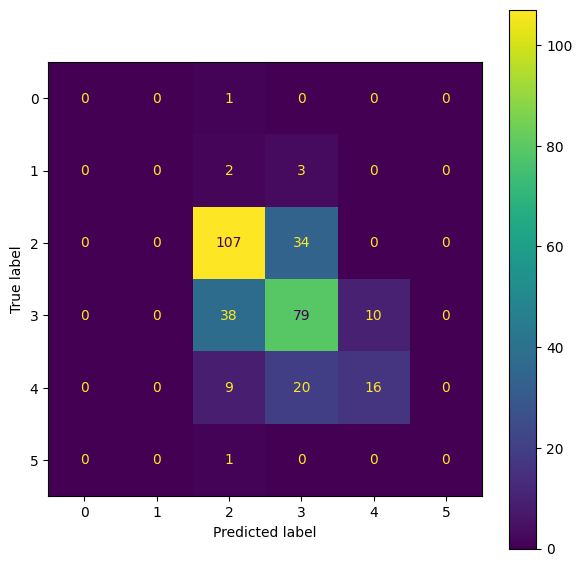

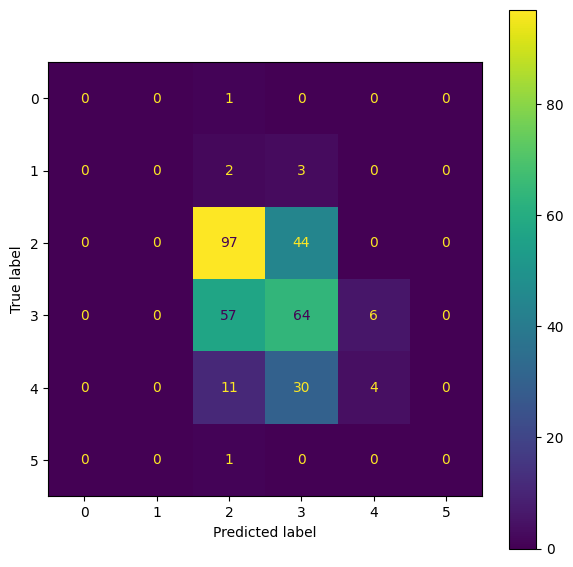

In [140]:
#матриця
y_pred = knn_a.predict(X_test)
cm_model1 = confusion_matrix(y_test, y_pred)
disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1)
fig, ax = plt.subplots(figsize=(7, 7))
disp_model1.plot(ax=ax)

plt.show()
y_pred = knn.predict(X_test)
cm_model1 = confusion_matrix(y_test, y_pred)
disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1)
fig, ax = plt.subplots(figsize=(7, 7))
disp_model1.plot(ax=ax)

plt.show()

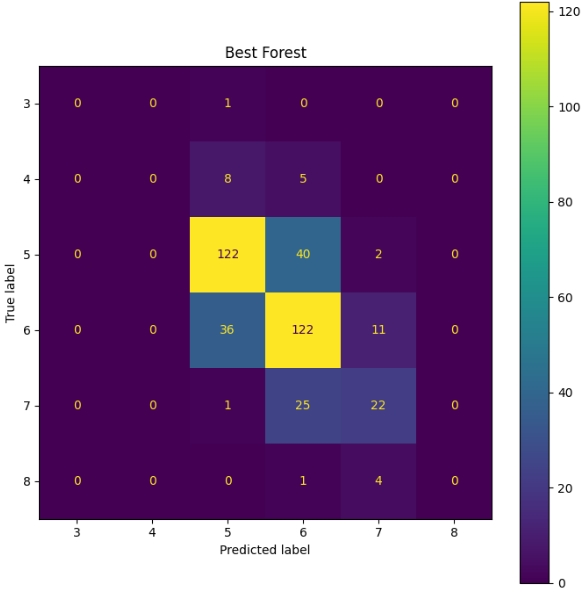

In [148]:
from IPython.display import Image

# Вставляємо зображення з локального файлу
Image(filename='image.jpg')